In [1]:
%load_ext autoreload
%autoreload 2

This notebook contains the training of ChromFormer on Trussart synthetic ClusterWalk data. This notebook contains as well structure prediction, confidence prediction and calibration models.

In [77]:
import torch
import random
import numpy as np
import os 
from torch_geometric.loader import DataLoader

from ChromFormer.Data_Tools.Data_Access import get_data_from_path, VanillaDataset, set_logits_data
from ChromFormer.Data_Tools.Data_Plotting import plot_structure_in_sphere, plot_hic, plot_optimal_transport, plot_losses, plot_test_distance_matrix, plot_true_pred_structures, plot_hist_kabsch_distances, plot_grad_flow, plot_pred_conf
from ChromFormer.Model.model import UniformLinear, train_uniform_linear, evaluate_uniform_linear, ConfLinear, train_conf_linear, evaluate_conf_linear, TransConf, train_trans_conf, evaluate_trans_conf
from ChromFormer.Model.losses import compute_trussart_test_kabsch_loss, biological_loss_fct, kabsch_loss_fct
from ChromFormer.Data_Tools.Data_Calculation import save_structure, import_trussart_data, kabsch_superimposition_numpy, kabsch_distance_numpy, make_gif, scale_logits, mse_unscaled_scaled
from ChromFormer.Model.lddt_tools import lddt, get_confidence_metrics
from ChromFormer.Model.calibration_nn import ModelWithTemperature, isotonic_calibration, beta_calibration
from scipy.spatial import distance_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
NB_HEAD = 2
NB_HIDDEN = 100
#100
NB_LAYERS = 1
DROPOUT = 0.1
SECD_HID = 48
#48
ZERO_INIT = False
EXPONENT = 1
NUM_BINS_LOGITS = 100
NB_EPOCHS = 96
##91
##47
SEED = 2
BATCH_SIZE = 10
NB_BINS = 202
EMBEDDING_SIZE = 3
ANGLE_PRED = 3
LAMBDA_BIO = 0.1
LAMBDA_KABSCH = 0.1
#0.1
LAMBDA_LDDT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
#The following uses the package python-dotenv that can be installed by pip to load the variable that contains your path to the data folder in a .env file 
DATA_DIR = os.environ.get('DATA_DIR')
DATA_PATH=f'{DATA_DIR}/biological_trussart_uniform'
TRAIN_DATASET_SIZE = 800
TEST_DATASET_SIZE = 200



The synthetic train and test distance structure and HiC matrices are first retrieved from the required data folder 

In [3]:
train_transfer_learning_hics, test_transfer_learning_hics, train_transfer_learning_structures, test_transfer_learning_structures, train_transfer_learning_distances, test_transfer_learning_distances = get_data_from_path(DATA_PATH)


Data is then loaded 

In [4]:
train_dataset = VanillaDataset(root = '', is_training = True, dataset_size = TRAIN_DATASET_SIZE, hics = train_transfer_learning_hics, structures = train_transfer_learning_structures, distances = train_transfer_learning_distances)
train_dataset = train_dataset.shuffle()
train_size = len(train_dataset)
print(train_size)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

800


In [5]:
test_dataset = VanillaDataset(root = '', is_training = False, dataset_size = TEST_DATASET_SIZE, hics = test_transfer_learning_hics, structures = test_transfer_learning_structures, distances = test_transfer_learning_distances)
test_dataset = test_dataset.shuffle()

test_train_idx, test_test_idx = train_test_split(list(range(len(test_dataset))), test_size=0.1)
test_train_calib = test_dataset.index_select(test_train_idx)
test_test_calib= test_dataset.index_select(test_test_idx)

test_size = len(test_dataset)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
test_train_calib_loader = DataLoader(test_train_calib, batch_size=BATCH_SIZE)
test_test_calib_loader = DataLoader(test_test_calib, batch_size=BATCH_SIZE)

Ground truth Trussart HiC and structures are imported

In [6]:
trussart_hic, trussart_structures = import_trussart_data(DATA_DIR)

In [7]:
distance_loss_fct = torch.nn.MSELoss()

The device on which to run the model is first selected, then the model is declared with the following parameters: NB_BINS is the number of loci in the structure, ANGLE_PRED is the same as the EMBEDDING_SIZE representing the 3d dimension embedding, NUM_BINS_LOGITS represents the number of confidence classes, ZERO_INIT decides whether to use a zero initialisation of the confidence learning wieghts or a Xavier initialisation, NB_HEAD is the number of heads in the encoder transformer layer, NB_HIDDEN is the first d projection dimension parameter as well as the number of feedforward passes in the first encoder layer, DROPOUT is the dropout rate of the transformer model, SECD_HID is the number of feedforward passes in the second encoder transformer layer. Then the optimizer is set to run on the model's parameters. 

In [8]:
device = torch.device('cpu')
model = TransConf(NB_BINS, ANGLE_PRED, BATCH_SIZE, NUM_BINS_LOGITS, ZERO_INIT, NB_HEAD, NB_HIDDEN, NB_LAYERS, DROPOUT, SECD_HID).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)

The following first trains the model with LAMBDA_KABSCH and LAMBDA_BIO being the weights of the kabsch and biological losses. LAMBDA_LDDT is the weight of the confidence loss. Then the model is evaluated with validation, testing and training results per epoch being stored in an array and being printed for the user to see. 

In [9]:
train_biological_losses_all_epochs = []
train_kabsch_losses_all_epochs = []
train_distance_losses_all_epochs = []
train_lddt_losses_all_epochs = []

test_biological_losses_all_epochs = []
test_kabsch_losses_all_epochs = []
test_distance_losses_all_epochs = []
test_lddt_losses_all_epochs = []

losses = []

trussart_test_kabsch_losses_all_epochs = []

for epoch in range(1, NB_EPOCHS+1):
    loss = train_trans_conf(model, train_loader, train_dataset, optimizer, device, BATCH_SIZE,  NB_BINS, EMBEDDING_SIZE, LAMBDA_BIO, LAMBDA_KABSCH, distance_loss_fct, LAMBDA_LDDT, NUM_BINS_LOGITS)
    losses.append(loss)
    
    ### Training
    train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, train_true_hics, \
        train_pred_structures, train_true_structures, train_pred_distances, \
            train_true_distances, train_mean_lddt_loss = evaluate_trans_conf(train_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    # Store results
    train_biological_losses_all_epochs.append(train_mean_biological_loss)
    train_kabsch_losses_all_epochs.append(train_mean_kabsch_loss)    
    train_distance_losses_all_epochs.append(train_mean_distance_loss)
    train_lddt_losses_all_epochs.append(train_mean_lddt_loss)

    ### Testing
    test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss, test_true_hics, \
        test_pred_structures, test_true_structures, test_pred_distances, \
            test_true_distances, test_mean_lddt_loss = evaluate_trans_conf(test_loader, model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, distance_loss_fct, NUM_BINS_LOGITS) 

    
    ### Trussart test
    trussart_test_kabsch_loss = compute_trussart_test_kabsch_loss(trussart_hic, trussart_structures, model, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    save_structure(model, epoch, trussart_structures, trussart_hic, NB_BINS, BATCH_SIZE, EMBEDDING_SIZE, True)
    # Store results
    test_biological_losses_all_epochs.append(test_mean_biological_loss)
    test_kabsch_losses_all_epochs.append(test_mean_kabsch_loss)    
    test_distance_losses_all_epochs.append(test_mean_distance_loss)
    test_lddt_losses_all_epochs.append(test_mean_lddt_loss)

    
    trussart_test_kabsch_losses_all_epochs.append(trussart_test_kabsch_loss)

    print('E: {:03d}, Tr B: {:.4f}, Tr K: {:.4f}, Tr D: {:.4f}, Te B: {:.4f}, Te K: {:.4f}, Te D: {:.4f}, Tr LD: {:.4f}, Te LD: {:.4f}, Trus: {:.4f}'.format(\
        epoch, train_mean_biological_loss, train_mean_kabsch_loss, train_mean_distance_loss, \
            test_mean_biological_loss, test_mean_kabsch_loss, test_mean_distance_loss,train_mean_lddt_loss, test_mean_lddt_loss, trussart_test_kabsch_loss))

E: 001, Tr B: 0.0186, Tr K: 0.1480, Tr D: 0.0690, Te B: 0.0222, Te K: 0.1526, Te D: 0.0674, Tr LD: 0.3637, Te LD: 0.3629, Trus: 0.1784
E: 002, Tr B: 0.0185, Tr K: 0.1255, Tr D: 0.0433, Te B: 0.0209, Te K: 0.1286, Te D: 0.0417, Tr LD: 0.3508, Te LD: 0.3470, Trus: 0.1560
E: 003, Tr B: 0.0181, Tr K: 0.1180, Tr D: 0.0375, Te B: 0.0199, Te K: 0.1217, Te D: 0.0373, Tr LD: 0.3427, Te LD: 0.3403, Trus: 0.1325
E: 004, Tr B: 0.0174, Tr K: 0.1156, Tr D: 0.0362, Te B: 0.0193, Te K: 0.1188, Te D: 0.0355, Tr LD: 0.3367, Te LD: 0.3344, Trus: 0.1232
E: 005, Tr B: 0.0174, Tr K: 0.1119, Tr D: 0.0341, Te B: 0.0195, Te K: 0.1151, Te D: 0.0335, Tr LD: 0.3371, Te LD: 0.3359, Trus: 0.1066
E: 006, Tr B: 0.0164, Tr K: 0.1079, Tr D: 0.0332, Te B: 0.0193, Te K: 0.1105, Te D: 0.0325, Tr LD: 0.3333, Te LD: 0.3324, Trus: 0.0991
E: 007, Tr B: 0.0167, Tr K: 0.1063, Tr D: 0.0336, Te B: 0.0191, Te K: 0.1090, Te D: 0.0339, Tr LD: 0.3299, Te LD: 0.3313, Trus: 0.0871
E: 008, Tr B: 0.0166, Tr K: 0.1048, Tr D: 0.0314, Te B:

Print where the minimum kabsch distance occured

In [10]:
print(np.where(trussart_test_kabsch_losses_all_epochs == min(trussart_test_kabsch_losses_all_epochs)))
print(min(trussart_test_kabsch_losses_all_epochs))

(array([95]),)
0.01785344708458357


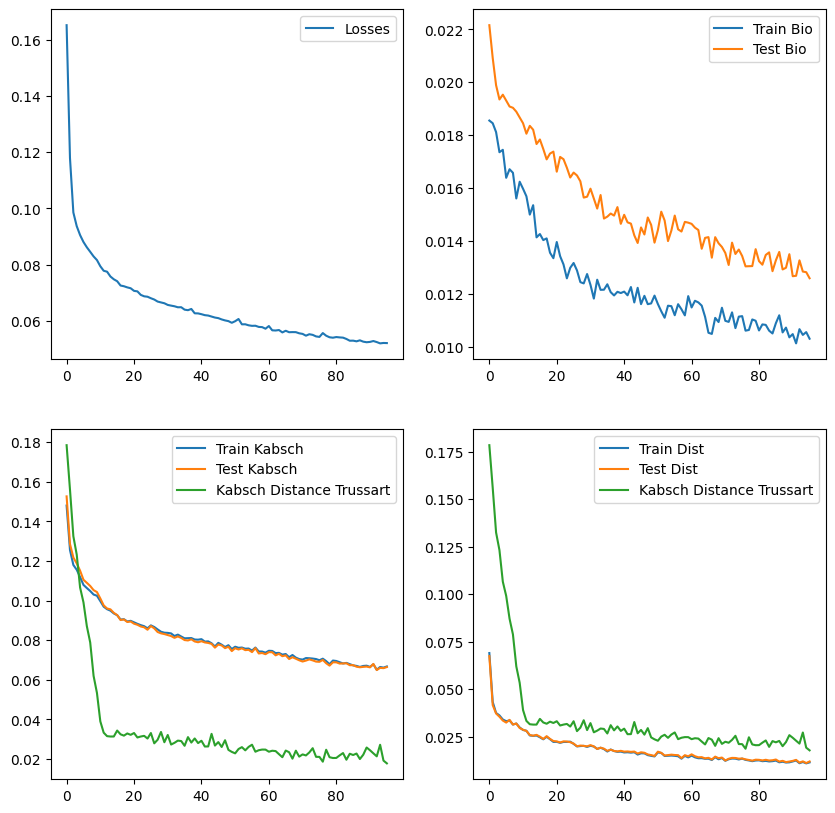

In [11]:
plot_losses(losses, train_biological_losses_all_epochs, test_biological_losses_all_epochs, train_kabsch_losses_all_epochs, test_kabsch_losses_all_epochs, trussart_test_kabsch_losses_all_epochs, train_distance_losses_all_epochs, test_distance_losses_all_epochs)


tensor(9.4149e-05)
transformer_encoder.encoder_layers.self_attn.in_proj_weight
tensor(7.2982e-05)
transformer_encoder.encoder_layers.self_attn.out_proj.weight
tensor(0.0001)
transformer_encoder.encoder_layers.linear1.weight
tensor(6.5400e-05)
transformer_encoder.encoder_layers.linear2.weight
tensor(0.0002)
transformer_encoder.encoder_layers.norm1.weight
tensor(0.0002)
transformer_encoder.encoder_layers.norm2.weight
tensor(8.3146e-05)
transformer_encoder.encoder_layers2.self_attn.in_proj_weight
tensor(5.8533e-05)
transformer_encoder.encoder_layers2.self_attn.out_proj.weight
tensor(9.2883e-05)
transformer_encoder.encoder_layers2.linear1.weight
tensor(4.3295e-05)
transformer_encoder.encoder_layers2.linear2.weight
tensor(0.0001)
transformer_encoder.encoder_layers2.norm1.weight
tensor(0.0002)
transformer_encoder.encoder_layers2.norm2.weight
tensor(9.8172e-05)
transformer_encoder.encoder.weight
tensor(0.0013)
transformer_encoder.decoder.weight
tensor(2.5712e-05)
linear_bin_layer.weight
tenso

/Users/hva/Documents/3D-Chromatin/Chromatin3D/Data_Tools/Data_Plotting.py:107: UserWarning:

Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



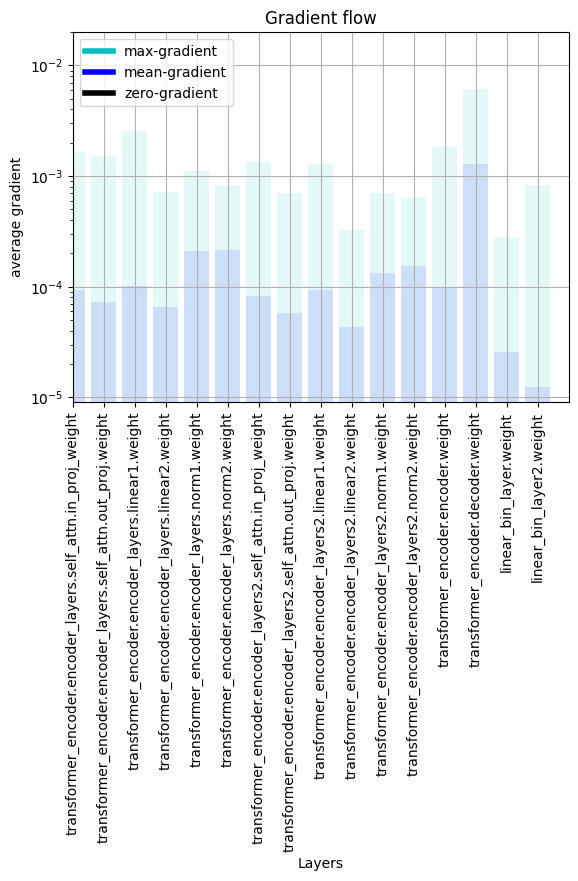

In [12]:
plot_grad_flow(model.named_parameters())

In [61]:
kabsch_distances = []

for graph_index in range(test_size):

    test_true_structure = test_true_structures[graph_index,:,:]
    test_pred_structure = test_pred_structures[graph_index,:,:]
    
    d = kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
    kabsch_distances.append(d)

In [62]:
sorted_kabsch = np.argsort(kabsch_distances)
print(sorted_kabsch)

[ 12  58   1 177  65 114 124 182  36   7  54  73 132  98   2 121 139 190
 168  66  22 194  48 112 134 175 155 147  42  31  72 172  21 150  78 197
 123  95  27  47 145  38  59  71 161 128 169 117  56 120 107 126 152  34
  85 111 165  35  18  29 193 186 105  83 171  75  24  39  69  91 143   4
  94 157  89  77 183 191 104  84  80   6  14  28  61 156 158 163  70 162
 116  30  97  25  74  52 180   5  50  37 106 101   8  13 173 127  67  55
  51  11 146 125  32  87  79  64 174 140 185  86 137 189 154 129  68  45
  90 110  17 184  60 195  81 199 131 151 164 196 166 115  40 153  53 198
  10 148  41 130 141  96 109 118 179 133  82 176  23  20  62  88   0 159
 102 170  63   3 100  43 135 113  92 181  49 103  57  26 149  19  15  76
 192 136  33 138  99  16 108 122 178 119 187   9  44 188 167 160 142 144
  46  93]


In [70]:
GRAPH_TESTED = sorted_kabsch[2]

True vs Pred synthetic validation distance matrices

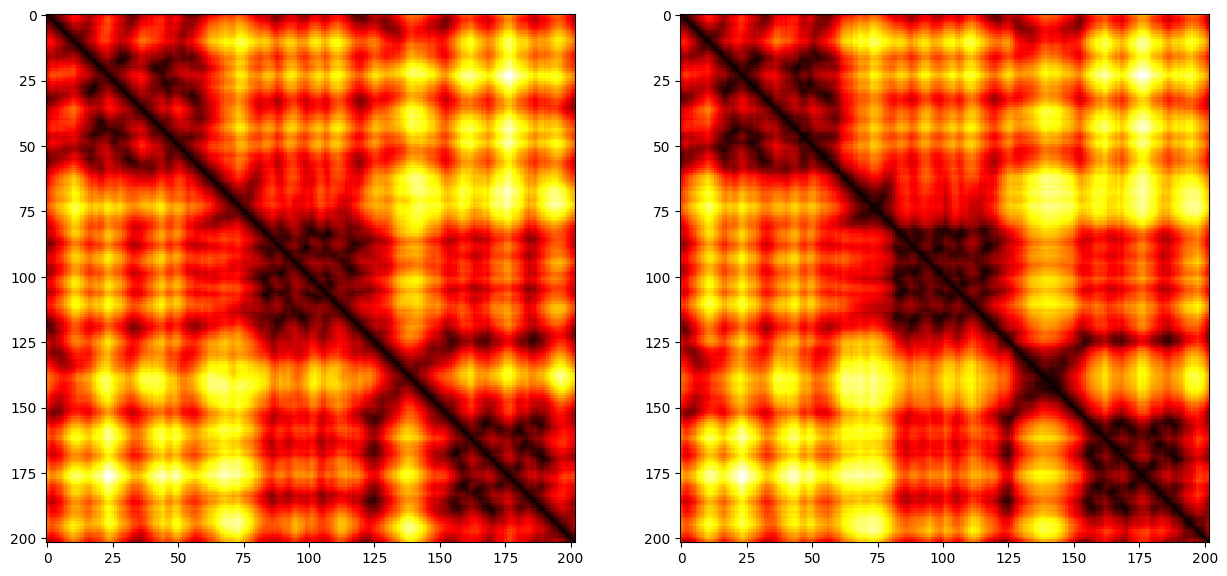

0.0073599685


In [76]:
ground_truth_matrix = test_true_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
reconstruction_matrix = test_pred_distances[GRAPH_TESTED*NB_BINS:GRAPH_TESTED*NB_BINS+NB_BINS, :]
plot_test_distance_matrix(ground_truth_matrix, reconstruction_matrix)
print(mean_squared_error(ground_truth_matrix, reconstruction_matrix))

Squared Error between them

In [86]:
se_distance_mat = np.square(ground_truth_matrix-reconstruction_matrix)


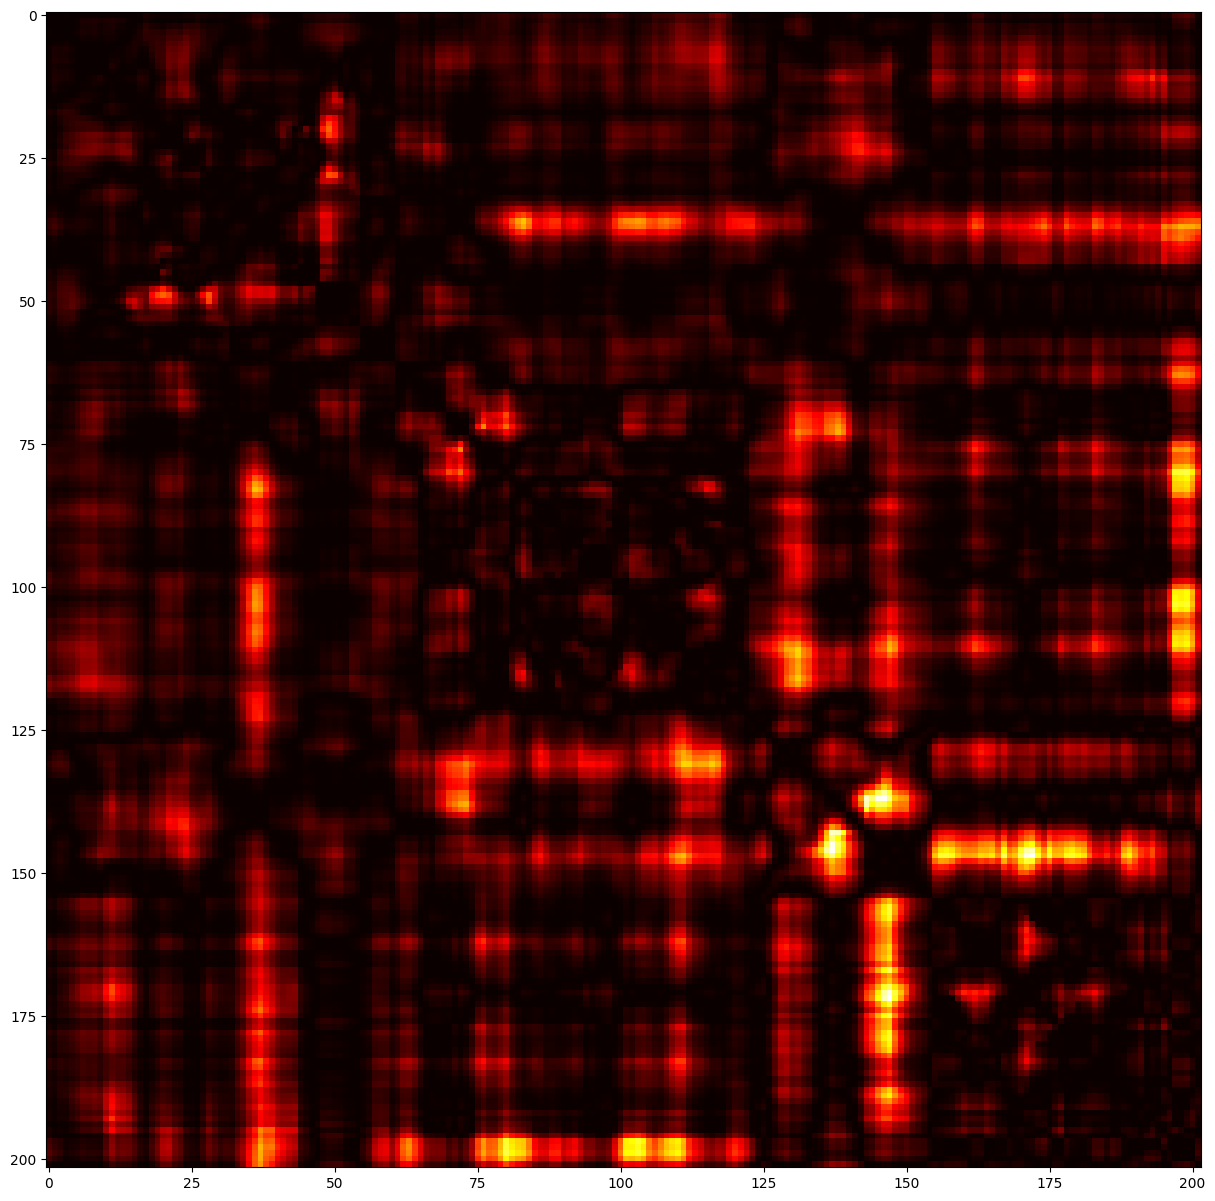

In [87]:
fig, axes = plt.subplots(figsize=(15,15))

axes.imshow(se_distance_mat, cmap='hot', interpolation='nearest')

plt.show()

True vs Pred synthetic validation structures

In [88]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)/3))



Kabsch distance is 0.00385368035855781


<Figure size 50000x50000 with 0 Axes>

In [74]:
color = 'magma'
plot_pred_conf(test_true_structure_superposed, np.asarray(range(len(x_true))), 'Viridis')

True vs Pred synthetic validation structures according to the pointwise error

In [18]:
test_true_structure = test_true_structures[GRAPH_TESTED]
test_pred_structure = test_pred_structures[GRAPH_TESTED]

test_pred_structure_superposed, test_true_structure_superposed = \
        kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)

x_pred = test_pred_structure_superposed[:, 0]  
y_pred = test_pred_structure_superposed[:, 1]
z_pred = test_pred_structure_superposed[:, 2]

x_true = test_true_structure_superposed[:, 0]  
y_true = test_true_structure_superposed[:, 1]
z_true = test_true_structure_superposed[:, 2]
pred_structure_unit_ball, true_structure_unit_ball = \
            kabsch_superimposition_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)
d = np.negative(np.log(np.mean(np.divide(np.abs(pred_structure_unit_ball - true_structure_unit_ball),np.abs(true_structure_unit_ball)), axis=1)))

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = d
color1 = 'Viridis'
color2 = 'magma'
plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(test_pred_structure, test_true_structure, EMBEDDING_SIZE)))



Kabsch distance is 0.008422994780143965


<Figure size 50000x50000 with 0 Axes>

Test to see if confidence method works as desired

In [19]:
random_structure = np.random.random((202,3))
test_true_structure = test_true_structures[GRAPH_TESTED]
print(lddt(torch.from_numpy(test_pred_structure_superposed).unsqueeze(0), torch.from_numpy(test_true_structure_superposed).unsqueeze(0)))

random_structure_superposed, true_to_random_structure_superposed = \
        kabsch_superimposition_numpy(random_structure, test_true_structure, EMBEDDING_SIZE)

print(lddt(torch.from_numpy(random_structure_superposed).unsqueeze(0), torch.from_numpy(true_to_random_structure_superposed).unsqueeze(0)))
#print(test_true_structures[GRAPH_TESTED].shape)


tensor([0.9078], dtype=torch.float64)
tensor([0.4906], dtype=torch.float64)


In [20]:
make_gif("", "gifs/trussart_linear.gif")

True consensus vs Pred Trussart structures

In [89]:
# Trussart perfect structure
trussart_true_structure = np.mean(trussart_structures, axis=0)

# Trussart predicted structure
torch_trussart_hic = torch.FloatTensor(trussart_hic)
torch_trussart_hic = torch.reshape(torch_trussart_hic, (1, NB_BINS, NB_BINS))
torch_trussart_hic = torch.repeat_interleave(torch_trussart_hic, BATCH_SIZE, 0)

trussart_pred_structure, trussart_pred_distance, trussart_pred_logits = model(torch_trussart_hic)
trussart_pred_structure = trussart_pred_structure.detach().numpy()[0]

# Superpose structure using Kabsch algorithm
trussart_pred_structure_superposed, trussart_true_structure_superposed = \
        kabsch_superimposition_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)

# Plot and compare the two structures
x_pred = trussart_pred_structure_superposed[:, 0]  
y_pred = trussart_pred_structure_superposed[:, 1]
z_pred = trussart_pred_structure_superposed[:, 2]

x_true = trussart_true_structure_superposed[:, 0]  
y_true = trussart_true_structure_superposed[:, 1]
z_true = trussart_true_structure_superposed[:, 2]

colorscale1 = np.asarray(range(len(x_true)))
colorscale2 = np.asarray(range(len(x_pred)))
color1 = 'Viridis'
color2 = 'Viridis'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_true, y_true, z_true, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)))

Kabsch distance is 0.017123802543628462


<Figure size 50000x50000 with 0 Axes>

predicted and true lddt prediction confidence of the trussart structure

In [90]:
confidence_metrics, pLLDTs = get_confidence_metrics(trussart_pred_logits.detach().numpy()[0])
print(confidence_metrics)

value = lddt(torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0),torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0), per_residue=True)
print(torch.mean(value))

#print(pLLDTs)
#print(value)

88.32430893836987
tensor(0.8972, dtype=torch.float64)


Predicted Trussart structure according to its pointwise confidence

In [91]:
color = 'magma'
plot_pred_conf(trussart_pred_structure_superposed, pLLDTs, color)

In [92]:
####Max error to confidence interval
dmat_true = torch.sqrt(1e-10 + torch.sum(
    (torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0)[:, :, None] - torch.from_numpy(trussart_true_structure_superposed).unsqueeze(0)[:, None, :])**2, axis=-1))
dmat_predicted = torch.sqrt(1e-10 + torch.sum(
    (torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0)[:, :, None] -
    torch.from_numpy(trussart_pred_structure_superposed).unsqueeze(0)[:, None, :])**2, axis=-1))

dists_to_score = (
    (dmat_true).type(torch.FloatTensor) *(1. - torch.eye(dmat_true.shape[1]))  
)

dist_l1 = torch.abs(dmat_true - dmat_predicted)
relative_error = torch.mean(torch.div(dist_l1, torch.abs(dmat_true))[0], dim=0)

print(relative_error.shape)
print(torch.topk(torch.mean(dist_l1[0],dim=0), k=10))
print(torch.topk(relative_error, k=10, largest=True))
print(np.argpartition(pLLDTs, 10)[:10])
print(torch.topk(value[0], k=10, largest=False))

torch.Size([202])
torch.return_types.topk(
values=tensor([0.1892, 0.1867, 0.1779, 0.1635, 0.1601, 0.1590, 0.1577, 0.1552, 0.1433,
        0.1433], dtype=torch.float64),
indices=tensor([ 87,  86,  30,  29, 121,  31,  85,  88,  28, 109]))
torch.return_types.topk(
values=tensor([0.2060, 0.2036, 0.1914, 0.1866, 0.1794, 0.1761, 0.1755, 0.1716, 0.1683,
        0.1638], dtype=torch.float64),
indices=tensor([ 87,  86, 121,  30,  85,  88,  29,  31, 120, 109]))
[ 76  15  73  74  75  77 129  14  72 130]
torch.return_types.topk(
values=tensor([0.7934, 0.7939, 0.8173, 0.8270, 0.8307, 0.8318, 0.8404, 0.8458, 0.8486,
        0.8519], dtype=torch.float64),
indices=tensor([ 86,  87,  85,  88, 121,  30,  29,  89,  31, 109]))


predicted and true confidence on predicted Trussart Structure

In [93]:


colorscale1 = -relative_error
colorscale2 = pLLDTs
color1 = 'magma'
color2 = 'magma'

plot_true_pred_structures(x_pred, y_pred, z_pred, x_pred, y_pred, z_pred, colorscale1, colorscale2, color1, color2)

# Shape comparison
print('Kabsch distance is ' + str(kabsch_distance_numpy(trussart_pred_structure, trussart_true_structure, EMBEDDING_SIZE)))

Kabsch distance is 0.017123802543628462


<Figure size 50000x50000 with 0 Axes>

In [101]:
color = 'magma'
plot_pred_conf(trussart_pred_structure_superposed, -relative_error, color)

Temperature Scaling

In [26]:
orig_model = model
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_test_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model = ModelWithTemperature(orig_model, device, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)
scaled_model.set_temperature(valid_loader)
m = torch.nn.LogSoftmax(dim=1)
nll_criterion = torch.nn.BCEWithLogitsLoss()
print(nll_criterion(m(logits_test_temp), labels_test_temp).item())
logits_test_temps_scaled = scaled_model.temperature_scale(logits_test_temp)

print(nll_criterion(m(logits_test_temps_scaled), labels_test_temp).item())

Before temperature - NLL: 0.037
tensor(0.7387, grad_fn=<MulBackward0>)
tensor(0.7385, grad_fn=<MulBackward0>)
tensor(0.7384, grad_fn=<MulBackward0>)
tensor(0.7383, grad_fn=<MulBackward0>)
tensor(0.7382, grad_fn=<MulBackward0>)
tensor(0.7380, grad_fn=<MulBackward0>)
tensor(0.7379, grad_fn=<MulBackward0>)
tensor(0.7378, grad_fn=<MulBackward0>)
tensor(0.7378, grad_fn=<MulBackward0>)
tensor(0.7377, grad_fn=<MulBackward0>)
tensor(0.7376, grad_fn=<MulBackward0>)
tensor(0.7375, grad_fn=<MulBackward0>)
tensor(0.7374, grad_fn=<MulBackward0>)
tensor(0.7374, grad_fn=<MulBackward0>)
tensor(0.7373, grad_fn=<MulBackward0>)
tensor(0.7373, grad_fn=<MulBackward0>)
tensor(0.7372, grad_fn=<MulBackward0>)
tensor(0.7372, grad_fn=<MulBackward0>)
tensor(0.7372, grad_fn=<MulBackward0>)
tensor(0.7371, grad_fn=<MulBackward0>)
tensor(0.7371, grad_fn=<MulBackward0>)
tensor(0.7371, grad_fn=<MulBackward0>)
tensor(0.7371, grad_fn=<MulBackward0>)
tensor(0.7371, grad_fn=<MulBackward0>)
tensor(0.7371, grad_fn=<MulBackw

Predicted scaled confidence for Temperature scaling

In [94]:
confidence_metric_scaled, plddt_scaled = scale_logits(trussart_pred_logits, scaled_model, BATCH_SIZE, NB_BINS)
print(confidence_metric_scaled)
print(plddt_scaled)

87.92110969759777
[86.44680102 86.60479872 86.78896943 86.80368605 86.79939757 86.92072648
 87.17511468 87.57461985 88.02812667 88.06274695 87.92950754 87.62726438
 87.1172463  86.62285709 86.32580224 85.95754088 86.34275317 86.73579403
 86.9332425  87.14850472 87.39987899 88.02926684 88.16040995 88.11911799
 88.07606344 88.36719985 88.59422214 88.60949535 88.35652096 88.25909888
 88.23678749 88.30327244 88.57838944 88.72366286 88.87135513 88.97754234
 89.05260115 89.50124845 89.70910905 89.81482935 89.94439278 89.82289928
 89.63217758 89.15216589 88.32549376 87.75054032 87.67049085 88.37228161
 88.62772451 88.86018417 88.58115874 88.3053769  87.85740827 87.42773198
 87.71680982 88.06940479 88.59822448 88.75019036 88.80840473 88.58950857
 88.19566565 88.19695318 87.81192517 87.93437774 88.14123805 88.51355245
 88.44216164 88.05367059 87.70842989 86.92035998 86.68737992 86.42181013
 86.25048095 85.74219142 85.50772624 85.4281093  85.48193562 86.18035327
 86.8820977  86.9663944  86.99868

Mean Squared error of calibrated and uncalibrated confidences

In [95]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, plddt_scaled)
print(mse_unscalled)
print(mse_scalled)

8.90396497944125
10.238485992420387


In [29]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

Isotonic Regression Calibration with predicted calibrated confidence

In [30]:
confidence_metric_iso, pLDDT_iso = isotonic_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_iso)
print(pLDDT_iso)

2.762019244488841
2.7228304028052044
88.419952212809
[86.96898656 87.13054857 87.37954055 87.47925764 87.56583559 87.66296394
 87.83733184 88.16966734 88.5087992  88.51954805 88.37719805 88.20907929
 87.72134378 87.06468983 86.80284679 86.46984973 86.91757734 87.46389197
 87.66047838 87.81728478 88.00475716 88.53079927 88.59887486 88.53571322
 88.50033466 88.78459422 88.9923114  89.00624571 88.76542421 88.65873145
 88.73502791 88.73754407 88.9655894  89.02660044 89.15718525 89.21954469
 89.32745206 89.77252985 89.88966391 90.00118223 90.10027795 89.99817787
 89.77950473 89.45127381 88.73014055 88.42993071 88.44641696 88.74465672
 89.03880874 89.21364899 89.01994178 88.73266378 88.52225906 88.18432871
 88.51692129 88.61353529 88.98201005 89.13995717 89.21452858 89.05241065
 88.76431523 88.69270071 88.53129867 88.56051103 88.68204898 88.97229275
 88.9361141  88.62154096 88.36567041 87.74803208 87.59158758 87.33406107
 87.1395394  86.47684274 86.21969241 86.06353794 86.17038753 86.8655510

MSE of unscalled and scalled confidences

In [31]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_iso)
print(mse_unscalled)
print(mse_scalled)

8.90396497944125
8.610143131413219


In [32]:
valid_loader = test_train_calib_loader
logits_test_temp, labels_test_temp = set_logits_data(test_train_calib_loader, device, model, BATCH_SIZE, NB_BINS, EMBEDDING_SIZE, NUM_BINS_LOGITS)

Beta Calibration with predicted calibrated confidence

In [33]:
confidence_metric_beta, pLDDT_beta = beta_calibration(logits_test_temp, labels_test_temp, trussart_pred_logits)
print(confidence_metric_beta)
print(pLDDT_beta)

2.762019244488841
2.690575990936544
88.35764786339571
[87.03672302 87.12357719 87.30420127 87.36226775 87.37850245 87.46894167
 87.68045396 88.01109202 88.4062404  88.44771243 88.30639744 88.02039284
 87.56515682 87.11872625 86.8687724  86.58491144 86.95966448 87.30066708
 87.45410385 87.60384912 87.84195279 88.40148277 88.51803029 88.48089152
 88.45811276 88.70725034 88.90959087 88.92261267 88.72560492 88.65725368
 88.66269069 88.71785563 88.91351327 89.02010095 89.12721122 89.21289096
 89.27347631 89.62172375 89.78613729 89.86108396 89.95785373 89.87043978
 89.73039962 89.37334514 88.75088566 88.27162708 88.26040394 88.80520894
 89.02280755 89.21538182 89.0050448  88.80096988 88.45253182 88.09278606
 88.31071252 88.61289832 89.00919002 89.12623326 89.14696312 89.0154454
 88.74518097 88.68567611 88.43012406 88.49262253 88.6744828  88.95404987
 88.90581607 88.58102755 88.30504249 87.67023985 87.41710362 87.18428112
 86.99149363 86.50435255 86.24332698 86.12706608 86.2301804  86.8687000

MSE of unscalled and scaled confidences

In [34]:
mse_unscalled, mse_scalled = mse_unscaled_scaled(value, pLLDTs, pLDDT_beta)
print(mse_unscalled)
print(mse_scalled)

8.90396497944125
8.777313127484609


Trussart predicted structure according to confidences calibrated with isotonic regression

In [99]:
color = 'magma'
plot_pred_conf(trussart_pred_structure_superposed, pLDDT_iso, color)

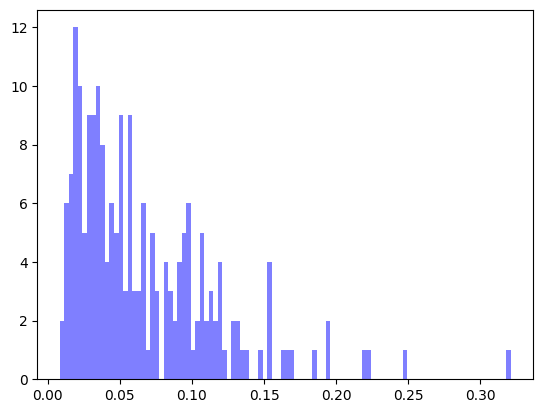

mean: 0.06646116296954313
median: 0.05114030383322206
variance: 0.002453008045144123


In [36]:
plot_hist_kabsch_distances(test_size, test_true_structures, test_pred_structures, EMBEDDING_SIZE)

In [37]:
RESULTS_ROOT = '../../saved_results/synthetic_biological_trussart_uniform_trans_conf/trans/'
LAMBDA_CONFIGURATION = str(25)

In [38]:
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_losses_' + LAMBDA_CONFIGURATION + '.txt', losses)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_train_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', train_biological_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_test_biological_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', test_biological_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_train_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', train_kabsch_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_test_kabsch_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_kabsch_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_train_distance_losses_all_epochs_' +
           LAMBDA_CONFIGURATION + '.txt', train_distance_losses_all_epochs)
np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_test_distance_losses_all_epochs_' + 
           LAMBDA_CONFIGURATION + '.txt', test_distance_losses_all_epochs)

np.savetxt(RESULTS_ROOT + 'synthetic_biological_trussart_uniform_trans_conf_trans_trussart_test_kabsch_losses_all_epochs_' +
               LAMBDA_CONFIGURATION + '.txt', trussart_test_kabsch_losses_all_epochs)

In [39]:
CONFORMATION =str(0)

In [40]:
np.savetxt(RESULTS_ROOT + '/structures/non_ae_synthetic_random_linear_trussart_test_structure_150_' +
               CONFORMATION + '.txt', trussart_pred_structure)

In [41]:
torch.save(model, 
           '../../saved_models/synthetic_biological_trussart_uniform_trans_conf/trans/synthetic_biological_trussart_uniform_linear_model_' + 
           LAMBDA_CONFIGURATION + '.pt')